In [193]:
from keras.layers import Input, Conv2D, Lambda, merge, Dense, Flatten,MaxPooling2D
from keras.models import Model, Sequential
from keras.regularizers import l2
from keras import backend as K
from keras.optimizers import SGD,Adam
from keras.losses import binary_crossentropy
import numpy.random as rng
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle
from numpy import array
from scipy.spatial.distance import cosine

%matplotlib inline

input_shape = (105, 105, 1)
left_input = Input(input_shape)
right_input = Input(input_shape)

## Data Loading
The data is pickled as an N_classes x n_examples x width x height array, and there is an accompanyng dictionary to specify which indexes belong to which languages.

In [25]:
#CHANGE THIS - path where the pickled data is stored
PATH = "/Users/Hernan/Documents/Artificial Intelligence, Msc - Essex/CE888 - Data Science and Big Data/oneshot-hb" 

# Loading 
with open(os.path.join(PATH, "train.pickle"), "rb") as f:
    (X,c) = pickle.load(f)

with open(os.path.join(PATH, "val.pickle"), "rb") as f:
    (Xval,cval) = pickle.load(f)
    
print("Training Alphabets")
print(c.keys())

print("\nValidation Alphabets:")
print(cval.keys())

alphabetSel = "Greek";
indexesForLang = c[alphabetSel]
totalCharactersLang = indexesForLang[1]-indexesForLang[0]+1
#print(c[alphabetSel])
print("\nTotal characters in Alphabet \"{0}\": {1}".format(alphabetSel, totalCharactersLang))

Training Alphabets
dict_keys(['Alphabet_of_the_Magi', 'Anglo-Saxon_Futhorc', 'Arcadian', 'Armenian', 'Asomtavruli_(Georgian)', 'Balinese', 'Bengali', 'Blackfoot_(Canadian_Aboriginal_Syllabics)', 'Braille', 'Burmese_(Myanmar)', 'Cyrillic', 'Early_Aramaic', 'Futurama', 'Grantha', 'Greek', 'Gujarati', 'Hebrew', 'Inuktitut_(Canadian_Aboriginal_Syllabics)', 'Japanese_(hiragana)', 'Japanese_(katakana)', 'Korean', 'Latin', 'Malay_(Jawi_-_Arabic)', 'Mkhedruli_(Georgian)', 'N_Ko', 'Ojibwe_(Canadian_Aboriginal_Syllabics)', 'Sanskrit', 'Syriac_(Estrangelo)', 'Tagalog', 'Tifinagh'])

Validation Alphabets:
dict_keys(['Angelic', 'Atemayar_Qelisayer', 'Atlantean', 'Aurek-Besh', 'Avesta', 'Ge_ez', 'Glagolitic', 'Gurmukhi', 'Kannada', 'Keble', 'Malayalam', 'Manipuri', 'Mongolian', 'Old_Church_Slavonic_(Cyrillic)', 'Oriya', 'Sylheti', 'Syriac_(Serto)', 'Tengwar', 'Tibetan', 'ULOG'])

Total characters in Alphabet "Greek": 24


In [26]:
class DatasetLoader:
    """Dataset loading batches (both training and testing/evaluation) separately """
    def __init__(self, path, data_subsets = ["train", "val"]):
        self.data = {}
        self.categories = {}
        self.info = {}
        
        for name in data_subsets:
            file_path = os.path.join(path, name + ".pickle")
            print("loading data from {}".format(file_path))
            with open(file_path,"rb") as f:
                (X,c) = pickle.load(f)
                self.data[name] = X
                self.categories[name] = c

    def get_batch(self,batch_size,s="train"):
        """Create batch of n pairs, half same class, half different class """
        X=self.data[s]
        n_classes, n_examples, w, h = X.shape
        #randomly sample several classes to use in the batch
        categories = rng.choice(n_classes,size=(batch_size,),replace=False)
        #initialize 2 empty arrays for the input image batch
        pairs=[np.zeros((batch_size, h, w,1)) for i in range(2)]
        #initialize vector for the targets, and make one half of it '1's, so 2nd half of batch has same class
        targets=np.zeros((batch_size,))
        targets[batch_size//2:] = 1
        for i in range(batch_size):
            category = categories[i]
            idx_1 = rng.randint(0, n_examples)
            pairs[0][i,:,:,:] = X[category, idx_1].reshape(w, h, 1)
            idx_2 = rng.randint(0, n_examples)
            
            """pick images of same class for 1st half, different for 2nd """
            if i >= batch_size // 2:
                category_2 = category  
            else: 
                #add a random number to the category modulo n classes to ensure 2nd image has
                # ..different category
                category_2 = (category + rng.randint(1,n_classes)) % n_classes
            pairs[1][i,:,:,:] = X[category_2,idx_2].reshape(w, h,1)
        return pairs, targets
    
    def generate(self, batch_size, s="train"):
        """a generator for batches, so model.fit_generator from keras/sk-learn can be used """
        while True:
            pairs, targets = self.get_batch(batch_size,s)
            yield (pairs, targets)    

    def make_oneshot_task(self,N,s="val",language=None):
        """Create pairs of test image, support set for testing N way one-shot learning. """
        X=self.data[s]
        n_classes, n_examples, w, h = X.shape
        indices = rng.randint(0,n_examples,size=(N,))
        if language is not None:
            low, high = self.categories[s][language]
            if N > high - low:
                raise ValueError("This language ({}) has less than {} letters".format(language, N))
            categories = rng.choice(range(low,high),size=(N,),replace=False)
            
        else:#if no language specified just pick a bunch of random letters
            categories = rng.choice(range(n_classes),size=(N,),replace=False)            
        true_category = categories[0]
        ex1, ex2 = rng.choice(n_examples,replace=False,size=(2,))
        test_image = np.asarray([X[true_category,ex1,:,:]]*N).reshape(N, w, h,1)
        support_set = X[categories,indices,:,:]
        support_set[0,:,:] = X[true_category,ex2]
        support_set = support_set.reshape(N, w, h,1) # N is the number of characters to compare
                                                     # w width h height and 1 is the RGB channels, just GREYSCALE 
        targets = np.zeros((N,))
        targets[0] = 1
        targets, test_image, support_set = shuffle(targets, test_image, support_set)
        pairs = [test_image,support_set]

        return pairs, targets
    
    ## ADDED NEW METHODS FOR TESTING AND TRAINNING THE MODEL
    def test_oneshot(self,model,N,k,s="val",verbose=0):
        """Test average N way oneshot learning accuracy of a siamese neural net over k one-shot tasks"""
        n_correct = 0
        if verbose:
            print("Evaluating model on {} random {} way one-shot learning tasks ...".format(k,N))
        for i in range(k):
            inputs, targets = self.make_oneshot_task(N,s)
            probs = model.predict(inputs)
            if np.argmax(probs) == np.argmax(targets):
                n_correct+=1
        percent_correct = (100.0*n_correct / k)
        if verbose:
            print("Got an average of {}% {} way one-shot learning accuracy".format(percent_correct,N))
        return percent_correct
    
    # Train the model that is contained in this class 
    def train(self, model, epochs, verbosity):
        model.fit_generator(self.generate(batch_size),)
    
#Instantiate an object of this defined class as "loader" 
loader = DatasetLoader(PATH)

loading data from /Users/Hernan/Documents/Artificial Intelligence, Msc - Essex/CE888 - Data Science and Big Data/oneshot-hb/train.pickle
loading data from /Users/Hernan/Documents/Artificial Intelligence, Msc - Essex/CE888 - Data Science and Big Data/oneshot-hb/val.pickle



# Shaping the Inputs in Pairwise 

In [381]:
def training_dataset_shaper(total_batch_p=100, verbose=False):

    #trainning model 
    total_batch = total_batch_p
    pairwise_size=6
    
    # TOTAL GENERATED PAIR IMAGES (INPUTS) WILL BE pairwise_size * total_batch
    XX = []
    YY = []

    for tot in range(total_batch):
        (pairs, targets)=loader.get_batch(pairwise_size, s="train")
        for i in range(pairwise_size):
            img1 = pairs[0][0].reshape(105,105).flatten()
            img2 = pairs[1][i].reshape(105,105).flatten()
            cosine_distance = cosine(img1, img2)
            # An Input will be composed of three features, the flatten img1 and img2 vector, plus their cosine distance
            #anInput = [img1, img2, cosine_distance]
            #anInput = [1,2,3]
            #anInput = img1
            anInput = cosine_distance
            XX.append(anInput)

        YY.append(targets.flatten())

    #print(XX)
    nXX = np.array(XX)
    nYY = np.array(YY).flatten()    
    #print(nXX.ndim)
    #print(nXX.shape)
    rows_size = pairwise_size*total_batch
    nXX = nXX.reshape(rows_size,1)
    if verbose:
        print(len(nXX))
        print(len(nYY))
        print(nXX)
        #print("\n"*2)
        print(nYY)
    
    return nXX, nYY

# Shaping the Test Set 

In [482]:
def testing_dataset_shaper(N_way=20, total_batch_p=1, verbose=False):
    #testing model 
    pairwise_size=N_way
    total_batch = total_batch_p

    # TOTAL GENERATED PAIR IMAGES (INPUTS) WILL BE pairwise_size * total_batch
    XX = []
    YY = []

    for tot in range(total_batch):
        s="val" # validation set
        (pairs, targets) = loader.make_oneshot_task(pairwise_size,s)
        #plot_oneshot_task(pairs)
        for i in range(pairwise_size):
            img1 = pairs[0][0].reshape(105,105).flatten()
            img2 = pairs[1][i].reshape(105,105).flatten()
            cosine_distance = cosine(img1, img2)
            # An Input will be composed of three features, the flatten img1 and img2 vector, 
            # plus their cosine distance        
            anInput = cosine_distance
            XX.append(anInput)

        YY.append(targets.flatten())

    #print(XX)
    nXX = np.array(XX)
    nYY = np.array(YY).flatten()    
    #print(nXX.ndim)
    #print(nXX.shape)
    rows_size = pairwise_size*total_batch
    nXX = nXX.reshape(rows_size,1)
    if verbose:
        print(len(nXX))
        print(len(nYY))
        print(nXX)
        #print("\n"*2)
        print(nYY)
    
    return nXX, nYY

In [375]:
X_test, y_test = testing_dataset_shaper(20, 1, True)

20
20
[[ 0.092738  ]
 [ 0.08766913]
 [ 0.07998051]
 [ 0.0664054 ]
 [ 0.07789573]
 [ 0.07956705]
 [ 0.07936371]
 [ 0.05609065]
 [ 0.06499422]
 [ 0.09305008]
 [ 0.06567408]
 [ 0.05632464]
 [ 0.05685162]
 [ 0.08075579]
 [ 0.06843818]
 [ 0.09481124]
 [ 0.07919744]
 [ 0.08006852]
 [ 0.06462546]
 [ 0.05159844]]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.
  0.  0.]


In [397]:
def pipeline_score_test_classifier(num_tests=100, verbose=False):
    score_test_tot=0
    test_count=num_tests
    for z in range(test_count):
        X_test, y_test = testing_dataset_shaper(20, 1)
        # calling the optimized CLASSIFIER TPOT
        score_test = pipeline_optimizer_classifier.score(X_test, y_test)
        score_test_tot +=score_test
        if verbose:            
            print(score_test)
    print("The total average score for {0}# of runs was: {1}".format(test_count,(score_test_tot/test_count)))

    
def pipeline_score_test_regressor(num_tests=100, verbose=False):
    score_test_tot=0
    test_count=num_tests
    for z in range(test_count):
        X_test, y_test = testing_dataset_shaper(20, 1)
        # calling the optimized REGRESSOR TPOT
        score_test = pipeline_optimizer_regressor.score(X_test, y_test)
        score_test_tot +=score_test
        if verbose:            
            print(score_test)
    print("The total average score for {0}# of runs was: {1}".format(test_count,(score_test_tot/test_count)))
    

# TPOT RandomForestClassifier Auto-ML

In [387]:
from tpot import TPOTClassifier
import numpy as np

tpot_config_classifier = {
    'sklearn.ensemble.RandomForestClassifier': {
        'n_estimators': [10, 20, 30, 40, 50, 100, 500, 1000],
        'max_leaf_nodes': ["None", 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
        'max_depth': ["None", 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
        'criterion': ["gini", "entropy"],
        'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10],
        'min_weight_fraction_leaf': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
        'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
        'min_impurity_decrease': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]       
    }
}
# 
#'class_weight': ["balanced", "balanced_subsample"]


pipeline_optimizer_classifier = TPOTClassifier(generations=5, population_size=10, verbosity=2,
                      config_dict=tpot_config_classifier)

nXX, nYY = training_dataset_shaper(10000,False)
pipeline_optimizer_classifier.fit(nXX, nYY)

pipeline_score_test_classifier(100, False)

pipeline_optimizer_classifier.export('tpot_exported_pipeline_classification.py')

Optimization Progress:  33%|███▎      | 20/60 [08:13<21:01, 31.53s/pipeline]

Generation 1 - Current best internal CV score: 0.5


Optimization Progress:  50%|█████     | 30/60 [09:46<04:26,  8.88s/pipeline]

Generation 2 - Current best internal CV score: 0.5


Optimization Progress:  67%|██████▋   | 40/60 [10:43<03:50, 11.51s/pipeline]

Generation 3 - Current best internal CV score: 0.5


Optimization Progress:  83%|████████▎ | 50/60 [13:12<01:43, 10.31s/pipeline]

Generation 4 - Current best internal CV score: 0.5


Generation 5 - Current best internal CV score: 0.5

Best pipeline: RandomForestClassifier(CombineDFs(input_matrix, input_matrix), criterion=gini, max_depth=1, max_leaf_nodes=9, min_impurity_decrease=0.2, min_samples_leaf=6, min_samples_split=4, min_weight_fraction_leaf=0.4, n_estimators=20)
The total average score for 100# of runs was: 0.9500000000000017


True

# TPOT RandomForest Classifier Optimized 
* Based on the Auto-ML tunning run above

In [392]:
# %load tpot_exported_pipeline_classification.py
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, make_union
from tpot.builtins import StackingEstimator
from sklearn.preprocessing import FunctionTransformer
from copy import copy
"""
# NOTE: Make sure that the class is labeled 'target' in the data file
tpot_data = pd.read_csv('.', sep='COLUMN_SEPARATOR', dtype=np.float64)
features = tpot_data.drop('target', axis=1).values
training_features, testing_features, training_target, testing_target = \
            train_test_split(features, tpot_data['target'].values, random_state=42)
"""
# Load the trainning and testing features
training_features = nXX
training_target = nYY
testing_features, _ = testing_dataset_shaper(20, 1)

# Score on the training set was:0.507
exported_pipeline = make_pipeline(
    make_union(
        FunctionTransformer(copy),
        FunctionTransformer(copy)
    ),
    RandomForestClassifier(criterion="gini", max_depth=1, max_leaf_nodes=9, min_impurity_decrease=0.2, min_samples_leaf=6, min_samples_split=4, min_weight_fraction_leaf=0.4, n_estimators=20)
)

exported_pipeline.fit(training_features, training_target)

results = exported_pipeline.predict(testing_features)

print(results)

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.]


# TPOT RandomForest REGRESSOR

In [483]:
from tpot import TPOTRegressor

tpot_config_regressor = {
    'sklearn.ensemble.RandomForestRegressor': {
    'n_estimators': [5,10,20,50,100,250],
    'min_samples_split': range(2, 21),
    'min_samples_leaf': range(1, 21),
    'max_features': ["auto", "sqrt", "log2"],
    'n_jobs': [-1]
    }
}
# 'max_depth': [2, 3, 4, 5, 6, 8, 10]        
            
    
pipeline_optimizer_regressor = TPOTRegressor(generations=5, population_size=20, verbosity=2,
                      config_dict=tpot_config_regressor)

#Pairwise training instances creator, shaped for input in sklearn
X_train, y_train = training_dataset_shaper(5000,False)

pipeline_optimizer_regressor.fit(X_train, y_train)

# calling score inside this function
pipeline_score_test_regressor(100, False)

for i in range(100):
    X_test, _ = testing_dataset_shaper(20, 1)
    results = pipeline_optimizer_regressor.predict(X_test)
    print(results)

#print(pipeline_optimizer_regressor.score(X_test, y_test))

pipeline_optimizer_regressor.export('tpot_REGRESSOR_pipeline.py')

Optimization Progress:  33%|███▎      | 40/120 [08:00<19:24, 14.56s/pipeline]

Generation 1 - Current best internal CV score: -0.26326407376346717


Optimization Progress:  50%|█████     | 60/120 [14:29<26:01, 26.02s/pipeline]

Generation 2 - Current best internal CV score: -0.2629951858038554


Optimization Progress:  67%|██████▋   | 80/120 [19:45<08:05, 12.13s/pipeline]

Generation 3 - Current best internal CV score: -0.2629951858038554


Optimization Progress:  83%|████████▎ | 100/120 [25:06<05:31, 16.57s/pipeline]

Generation 4 - Current best internal CV score: -0.2629951858038554


Generation 5 - Current best internal CV score: -0.26168970343654274

Best pipeline: RandomForestRegressor(input_matrix, max_features=log2, min_samples_leaf=20, min_samples_split=18, n_estimators=250, n_jobs=-1)
The total average score for 100# of runs was: -0.26062240778656665
[ 0.44032452  0.39267788  0.6456478   0.69996787  0.51164272  0.54239644
  0.37842894  0.45687736  0.64151012  0.59661279  0.35321627  0.48450099
  0.61386278  0.55975567  0.63542383  0.55865361  0.55109944  0.54239018
  0.34355162  0.66600312]
[ 0.54059902  0.50136515  0.39116138  0.50252763  0.43744225  0.50400577
  0.46111857  0.57438848  0.52403089  0.52457639  0.42581047  0.48753872
  0.45220272  0.51091254  0.49336608  0.48329665  0.53761696  0.3541871
  0.55695702  0.40639369]
[ 0.66359042  0.59843505  0.65900836  0.68668002  0.59895371  0.57874273
  0.57205713  0.52538187  0.36150952  0.54076849  0.26831728  0.37841169
  0.43648611  0.42348657  0.62354448  0.68213018  0.29409239  0.41488089
  0.48733728  

[ 0.31642132  0.31343511  0.51519479  0.53251948  0.60142481  0.49806104
  0.44606024  0.40190387  0.57851419  0.53254921  0.61761686  0.34638074
  0.45763894  0.67456472  0.51757756  0.65121546  0.36663222  0.27922132
  0.5954094   0.40155462]
[ 0.4993806   0.49936875  0.5247272   0.46876973  0.66460874  0.35080732
  0.55071694  0.43144535  0.59309948  0.43359512  0.59620537  0.57887894
  0.52269117  0.38802271  0.64643044  0.41049776  0.67989809  0.38910741
  0.53842771  0.5181132 ]
[ 0.55554746  0.60455623  0.53962915  0.39484401  0.60399233  0.55863657
  0.35564189  0.53093451  0.62076262  0.7250314   0.46174642  0.4704516
  0.49378421  0.61301216  0.51629932  0.45552812  0.60960351  0.61024831
  0.42353822  0.46168314]
[ 0.50691376  0.40818688  0.62311445  0.50998658  0.50530494  0.71410405
  0.45244434  0.49346363  0.57022553  0.55037741  0.45193074  0.54166794
  0.60994079  0.58690746  0.6271591   0.40608561  0.46743758  0.50905447
  0.8013276   0.49430253]
[ 0.55194121  0.41545

[ 0.45180189  0.48571104  0.44668345  0.47152192  0.64529267  0.50206852
  0.66983876  0.54115991  0.50435212  0.48115867  0.23139409  0.63088297
  0.43020238  0.64011516  0.45712423  0.39085964  0.35795424  0.41652112
  0.46215247  0.38608774]
[ 0.44440352  0.47848508  0.46342006  0.28086356  0.37955651  0.51938455
  0.33904719  0.32524995  0.38694507  0.42351678  0.54435235  0.60124274
  0.49271597  0.43956325  0.34621736  0.55850894  0.44894393  0.32956568
  0.54520578  0.65828817]
[ 0.33132596  0.54650609  0.42558064  0.36357023  0.64778224  0.67447084
  0.65422298  0.3717589   0.41451748  0.47289358  0.60415151  0.45706559
  0.5367123   0.50644296  0.40096424  0.60132217  0.28440423  0.43566631
  0.46804745  0.48446517]
[ 0.5959419   0.35636302  0.41307856  0.44798731  0.34653008  0.41837857
  0.29587878  0.6529312   0.48460869  0.57566062  0.36670354  0.42504751
  0.38670264  0.66004804  0.54616075  0.6818265   0.6116596   0.51126251
  0.67086811  0.29106844]
[ 0.54730299  0.6555

True

In [411]:
# calling TPOT score method inside this function
pipeline_score_test_regressor(100, False)
print("\n")

cant=0
total_runs = 10;
N_ways=20
for i in range(total_runs):
    X_test, y_test = testing_dataset_shaper(N_ways, 1)
    results = pipeline_optimizer_regressor.predict(X_test)
    print(results)
    if np.argmax(y_test) == np.argmin(results):
        print("CORRECT!")
        cant = cant+1 

print("{0} way TPOT RandomForest Regressor Accuracy in {1} runs was: {2}%".format(N_ways,total_runs,cant*100/total_runs))
# 1000 inputs: 21.4% accuracy -> 5 Way 
# 1000 inputs: 36% accuracy -> 20 Way 

# 100 inputs: 20% accuracy -> 5 Way 
# 100 inputs: 6% accuracy -> 20 Way 


#print(pipeline_optimizer_regressor.score(X_test, y_test))

pipeline_optimizer_regressor.export('tpot_REGRESSOR_pipeline.py')

The total average score for 100# of runs was: -0.25945194593192333
[ 0.43621466  0.46844895  0.49855135  0.49331865  0.49815488  0.50806607
  0.60254379  0.59529056  0.34975262  0.39650047  0.34553322  0.47141318
  0.4634443   0.52356156  0.5962314   0.64465393  0.42040722  0.35602034
  0.3987375   0.42045262]
[ 0.6047783   0.49864691  0.34552285  0.60974832  0.48453777  0.57226698
  0.38463461  0.44136002  0.46163732  0.34677431  0.55239521  0.38995578
  0.41127521  0.61302073  0.56301012  0.49199251  0.49202948  0.34076587
  0.58329541  0.46481518]
[ 0.45487627  0.43450948  0.56350265  0.55731699  0.5589978   0.3845105
  0.45996526  0.61390973  0.63528392  0.33965109  0.62777996  0.50065994
  0.38414627  0.51953663  0.45585733  0.49122943  0.5697502   0.55000823
  0.47390811  0.58615767]
[ 0.62859666  0.37418487  0.59435446  0.31336166  0.52356156  0.36640505
  0.69640131  0.58145663  0.34264805  0.4193157   0.69249231  0.46784677
  0.61204154  0.5015553   0.44642688  0.34746565  0.2

True

In [467]:
from sklearn.neighbors import KNeighborsClassifier

# Custom distance function for KNN
def custom_distance(X, Y):
    img1 = pipeline_optimizer_regressor.predict(X.reshape(1,1))
    img2 = pipeline_optimizer_regressor.predict(Y.reshape(1,1))
    dist=abs(img1-img2)
    #print(img1, img2, dist)
    #print("X: ", X, X.shape)
    #print("Y: ", Y, Y.shape)
    #returns a float with the distance between the two images.
    #return abs(dist1 - dist2)
    return dist

X_train, Y_train = training_dataset_shaper(20,False) #impossible to calculate with 100 runs which is 600 pairs

knnCustomMetric = KNeighborsClassifier(n_neighbors=1, metric=custom_distance) #algorithm='ball_tree'
knnCustomMetric.fit(X_train, Y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30,
           metric=<function custom_distance at 0x1a2b0662f0>,
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform')

In [477]:
def knn_custom_metric_acc(nWay=5, tot_runs=10):
    cant=0
    total_runs = tot_runs;
    N_ways=nWay
    for i in range(total_runs):
        X_test, y_test = testing_dataset_shaper(N_ways, 1)
        #results = knnCustomMetric.predict(X_test)
        results = knnCustomMetric.kneighbors(X_test,1,return_distance=False) 
        print(results)
        print("*******")
        if np.argmax(y_test) == np.argmin(results):
            print("CORRECT!")
            cant = cant+1 

    print("{0} way KNN Custom Distance Metric Accuracy in {1} runs was: {2}%".format(N_ways,total_runs,cant*100/total_runs))

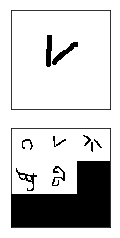

[[ 33]
 [ 71]
 [104]
 [ 64]
 [ 33]]
*******


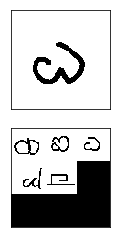

[[112]
 [ 31]
 [ 71]
 [ 33]
 [106]]
*******


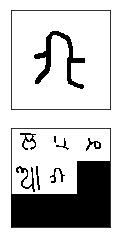

[[15]
 [11]
 [28]
 [ 5]
 [68]]
*******
5 way KNN Custom Distance Metric Accuracy in 3 runs was: 0.0%


In [478]:
knn_custom_metric_acc(5,3)

(2, 5, 105, 105, 1)
[ 0.  0.  0.  1.  0.]


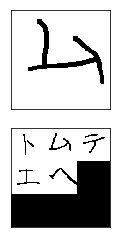

In [412]:
# Showing/Plotting the characters
def concat_images(X):
    """Concatenates a bunch of images into a big matrix for plotting purposes."""
    nc,h,w,_ = X.shape
    X = X.reshape(nc,h,w)
    n = np.ceil(np.sqrt(nc)).astype("int8")
    img = np.zeros((n*w,n*h))
    x = 0
    y = 0
    for example in range(nc):
        img[x*w:(x+1)*w,y*h:(y+1)*h] = X[example]
        y += 1
        if y >= n:
            y = 0
            x += 1
    return img


def plot_oneshot_task(pairs):
    """Takes a one-shot task (in pairs) given and returns the plot of the selected characters to train """
    fig,(ax1,ax2) = plt.subplots(2)
    ax1.matshow(pairs[0][0].reshape(105,105),cmap='gray')
    img = concat_images(pairs[1])
    ax1.get_yaxis().set_visible(False)
    ax1.get_xaxis().set_visible(False)
    ax2.matshow(img,cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.show()

def plot_oneshot_task_n(pairs,i):
    """Takes a one-shot task (in pairs) given and returns the plot of the selected characters to train """
    fig,(ax1,ax2) = plt.subplots(2)
    #ax1.matshow(pairs[0][0].reshape(105,105),cmap='gray')
    """
    if i <= 1:
        ax1.matshow(pairs[i][0].reshape(105,105),cmap='gray')
    else:
        ax1.matshow(pairs[1][i-1].reshape(105,105),cmap='gray')
    """
    # show all the characters selected to train/train in the array
    ax1.matshow(pairs[0][i].reshape(105,105),cmap='gray')

    img = concat_images(pairs[1])
    ax1.get_yaxis().set_visible(False)
    ax1.get_xaxis().set_visible(False)
    ax2.matshow(img,cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.show()

    
#Examples of one-shot learning tasks in the training dataset 
pairs, targets = loader.make_oneshot_task(5,"train","Greek")
#plot_oneshot_task(pairs)
print(array(pairs).shape)
print (targets)

"""
for i in range(0, 5):
    plot_oneshot_task_n(pairs,i)
"""

pairs, targets = loader.make_oneshot_task(5,"train","Japanese_(katakana)")
plot_oneshot_task(pairs)


In [433]:
from scipy.spatial.distance import directed_hausdorff
from scipy.spatial.distance import cosine

def k_nearest_neighbour_correct(pairs,targets):
    """returns 1 if nearest neighbour gets the correct answer for a one-shot task
        given by (pairs, targets)"""
    L2_distances = np.zeros_like(targets)
    for i in range(len(targets)):
        L2_distances[i] = np.sum(np.sqrt(pairs[0][i]**2 - pairs[1][i]**2))
    if np.argmin(L2_distances) == np.argmax(targets):
        return 1
    return 0

######################################################
# Test Knn accuracy with L2 distance
def test_knn_accuracy(N_ways,n_trials,loader):
    """Returns accuracy of one shot """
    print("Evaluating KNN with L2 DISTANCE on {} unique {} way one-shot learning tasks ...".format(n_trials,N_ways))

    n_right = 0
    
    for i in range(n_trials):
        pairs,targets = loader.make_oneshot_task(N_ways,"val")
        correct = k_nearest_neighbour_correct(pairs,targets)
        n_right += correct
    return 100.0 * n_right / n_trials


####################################################

def k_nearest_neighbour_hausdorff(pairs,targets):
    """returns 1 if nearest neighbour gets the correct answer for a one-shot task
        given by (pairs, targets)"""

    hausdorff_distances=[None]*len(targets)
    for i in range(0,len(targets)):
        hausdorff_distances[i] = directed_hausdorff(pairs[0][0].reshape(105,105), pairs[1][i].reshape(105,105),13)
        #print("The distance is: {0}".format(hausdorff_distances[i][0]))    
    if np.argmin(hausdorff_distances) == np.argmax(targets):
        return 1
    return 0

def test_knn_hausdorff_accuracy(N_ways,n_trials,loader):
    """Returns accuracy of one shot """
    print("Evaluating KNN with HAUSDORFF on {} unique {} way one-shot learning tasks ...".format(n_trials,N_ways))

    n_right = 0
    
    for i in range(n_trials):
        pairs,targets = loader.make_oneshot_task(N_ways,"val")
        correct = k_nearest_neighbour_hausdorff(pairs,targets)
        n_right += correct
    return 100.0 * n_right / n_trials

######################################################

def k_nearest_neighbour_cosine(pairs,targets):
    """returns 1 if nearest neighbour gets the correct answer for a one-shot task
        given by (pairs, targets)"""

    cosine_distances=[None]*len(targets)
    for i in range(0,len(targets)):
        cosine_distances[i] = cosine(pairs[0][i].reshape(105,105).flatten(), pairs[1][i].reshape(105,105).flatten())
    if np.argmin(cosine_distances) == np.argmax(targets):
        return 1
    return 0

def test_knn_cosine_accuracy(N_ways,n_trials,loader):
    """Returns accuracy of one shot """
    print("Evaluating KNN with COSINE distance on {} unique {} way one-shot learning tasks ...".format(n_trials,N_ways))
    n_right = 0
    for i in range(n_trials):
        pairs,targets = loader.make_oneshot_task(N_ways,"val")
        correct = k_nearest_neighbour_cosine(pairs,targets)
        n_right += correct
    return 100.0 * n_right / n_trials

######################################################


ways = np.arange(1, 60, 2)
resume =  False
val_accs, train_accs,knn_accs = [], [], []
trials = 450
#for N in ways:
    #val_accs.append(loader.test_oneshot(siamese_net, N,trials, "val", verbose=True))
    #train_accs.append(loader.test_oneshot(siamese_net, N,trials, "train", verbose=True))
    #knn_accs.append(test_knn_accuracy(N,trials, loader))
    
#plot the accuracy vs num categories for each
#plt.plot(ways, val_accs, "m")
#plt.plot(ways, train_accs, "y")
#plt.plot(ways, knn_accs, "c")

#plt.plot(ways,100.0/ways,"r")
#plt.show()

In [434]:
# KNN with L2 distances for 5 way one-shot learning
a=test_knn_accuracy(5,1000,loader)
print(a)

Evaluating KNN with L2 DISTANCE on 1000 unique 5 way one-shot learning tasks ...
46.5


In [430]:
# KNN with L2 distances for 20 way one-shot learning
a=test_knn_accuracy(20,1000,loader)
print(a)

Evaluating KNN with L2 DISTANCE on 1000 unique 20 way one-shot learning tasks ...
27.7


In [431]:
a=test_knn_hausdorff_accuracy(5,1000,loader)
print(a)

Evaluating KNN with HAUSDORFF on 1000 unique 5 way one-shot learning tasks ...
8.8


In [435]:
a=test_knn_cosine_accuracy(5,1000,loader)
print(a)

Evaluating KNN with COSINE distance on 1000 unique 5 way one-shot learning tasks ...
35.5


In [436]:
a=test_knn_cosine_accuracy(20,1000,loader)
print(a)

Evaluating KNN with COSINE distance on 1000 unique 20 way one-shot learning tasks ...
14.2


# Visualization / Interpretation of Hausdorff Distance
* Based on the 105 x 105 px centered images of the Omniglot Dataset

The distance is: 845.739321540627
The distance is: 919.4155752433172
The distance is: 845.739321540627
The distance is: 883.3459118601274
The distance is: 721.2489168102785


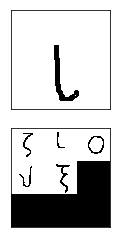

Each number corresponds in order (from left to right) to the distance of each image with respect of the original letter(input) in the last array displayed 


In [420]:
pairs, targets = loader.make_oneshot_task(5,"train","Greek")

for i in range(len(targets)):
    hausdorff_distance = directed_hausdorff(pairs[0][i].reshape(105,105), pairs[1][i].reshape(105,105))
    print("The distance is: {0}".format(hausdorff_distance[0])) 

plot_oneshot_task(pairs)
print("Each number corresponds in order (from left to right) to the distance \
of each image with respect of the original letter(input) in the last array displayed ")

# Visualization / Interpretation of Jaccard Similarity
* Based on the 105 x 105 px centered images of the Omniglot Dataset

The distance is: 0.9059410430839002
The distance is: 0.9016780045351473
The distance is: 0.9338775510204081
The distance is: 0.910657596371882
The distance is: 0.9022222222222223


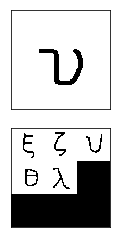

Each number corresponds in order (from left to right) to the distance of each image with respect of the original letter(input) in the last array displayed 


In [424]:
from sklearn.metrics import jaccard_similarity_score

pairs, targets = loader.make_oneshot_task(5,"train","Greek")

for i in range(len(targets)):
    jacc = jaccard_similarity_score(pairs[0][i].reshape(105,105).flatten(), pairs[1][i].reshape(105,105).flatten())
    print("The distance is: {0}".format(jacc)) 
plot_oneshot_task(pairs)
print("Each number corresponds in order (from left to right) to the distance of each image with respect \
of the original letter(input) in the last array displayed ")

# Visualization / Interpretation of Cosine Distance
* Based on the 105 x 105 px centered images of the Omniglot Dataset
* This distance is the one used to achieve state-of-the-art results in past papers (as mentioned in mine)

The distance is: 0.05650226497830746
The distance is: 0.04259592942974666
The distance is: 0.05143660472908207
The distance is: 0.032087352213636455
The distance is: 0.05898739493833238


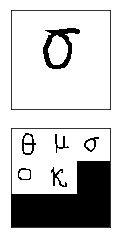

In [182]:
from scipy.spatial.distance import cosine

pairs, targets = loader.make_oneshot_task(5,"train","Greek")
for i in range(len(targets)):
    cosd = cosine(pairs[0][i].reshape(105,105).flatten(), pairs[1][i].reshape(105,105).flatten())
    print("The distance is: {0}".format(cosd)) 
plot_oneshot_task(pairs)